# Guide pour l'Appel à une API Hugging Face pour la Segmentation d'Images

Bienvenue ! Ce notebook a pour but de vous guider pas à pas dans l'utilisation de l'API d'inférence de Hugging Face pour effectuer de la segmentation d'images. La segmentation d'images consiste à attribuer une étiquette (comme "cheveux", "vêtement", "arrière-plan") à chaque pixel d'une image.

Nous allons :
1. Comprendre ce qu'est une API et comment s'y connecter.
2. Envoyer une image à un modèle de segmentation hébergé sur Hugging Face.
3. Récupérer et interpréter les résultats.
4. Visualiser les masques de segmentation.
5. Étendre cela pour traiter plusieurs images.

## 1. Configuration Initiale et Importations

Commençons par importer les bibliothèques Python nécessaires. Nous aurons besoin de :
- `os` pour interagir avec le système de fichiers (lister les images).
- `requests` pour effectuer des requêtes HTTP vers l'API.
- `PIL (Pillow)` pour manipuler les images.
- `matplotlib.pyplot` pour afficher les images et les masques.
- `numpy` pour la manipulation des tableaux (les images sont des tableaux de pixels).
- `tqdm.notebook` pour afficher une barre de progression (utile pour plusieurs images).
- `base64` et `io` pour décoder les masques renvoyés par l'API.

In [19]:
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from tqdm.notebook import tqdm
import base64
import io
from dotenv import load_dotenv
from huggingface_hub import InferenceClient

### Variables de Configuration

Nous devons définir quelques variables :
- `image_dir`: Le chemin vers le dossier contenant vos images. **Assurez-vous de modifier ce chemin si nécessaire.**
- `max_images`: Le nombre maximum d'images à traiter (pour ne pas surcharger l'API ou attendre trop longtemps).
- `api_token`: Votre jeton d'API Hugging Face. **IMPORTANT : Gardez ce jeton secret !**

**Comment obtenir un token API Hugging Face ?**
1. Créez un compte sur [huggingface.co](https://huggingface.co/).
2. Allez dans votre profil -> Settings -> Access Tokens.
3. Créez un nouveau token (par exemple, avec le rôle "read").
4. Copiez ce token ici.

In [20]:
# TODO: Modifiez ces valeurs selon votre configuration
image_dir = "./images_a_segmenter"  # Exemple : si vous êtes sur Colab et avez uploadé un dossier
max_images = 3  # Commençons avec peu d'images

# IMPORTANT: Remplacez "VOTRE_TOKEN_HUGGING_FACE_ICI" par votre véritable token API.
# Ne partagez jamais votre token publiquement.
# Charge les variables. Si le .env est dans le même dossier que le notebook, c'est direct.
# Sinon, vous devrez peut-être spécifier le chemin :
# load_dotenv('/chemin/vers/votre/.env')
load_dotenv()

# Récupérer le token Hugging Face
api_token = os.getenv("HUGGING_FACE_TOKEN")

if api_token:
    print("✅ Le token Hugging Face a été chargé depuis le .env.")
    # Vous pouvez maintenant utiliser hf_token pour vous connecter à Hugging Face
    # depuis ce Notebook.
else:
    print("❌ Erreur : Le token n'a pas été trouvé. Vérifiez le fichier .env.")

# Créons le dossier d'images s'il n'existe pas (pour l'exemple)
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
    print(f"Dossier '{image_dir}' créé. Veuillez y ajouter des images .jpg ou .png.")
else:
    print(f"Dossier '{image_dir}' existant.")


✅ Le token Hugging Face a été chargé depuis le .env.
Dossier './images_a_segmenter' existant.


## 2. Comprendre l'API d'Inférence Hugging Face

L'API d'inférence permet d'utiliser des modèles hébergés sur Hugging Face sans avoir à les télécharger ou à gérer l'infrastructure.

- **Modèle utilisé** : Nous allons utiliser le modèle `sayeed99/segformer_b3_clothes`, spécialisé dans la segmentation de vêtements et de parties du corps.
- **URL de l'API** : L'URL pour un modèle est généralement `https://api-inference.huggingface.co/models/NOM_DU_MODELE`.
- **Headers (En-têtes)** : Pour s'authentifier et spécifier le type de contenu, nous envoyons des en-têtes avec notre requête.
    - `Authorization`: Contient notre token API (précédé de `Bearer `).
    - `Content-Type`: Indique que nous envoyons une image au format JPEG (ou PNG selon le cas).

In [21]:
#erreur 410 avec : "https://api-inference.huggingface.co/models/sayeed99/segformer_b3_clothes"
API_URL = "https://router.huggingface.co/models/sayeed99/segformer-b3-clothes" # Remplacez ... par le bon endpoint.
headers = {
    "Authorization": f"Bearer {api_token}"
    # Le "Content-Type" sera ajouté dynamiquement lors de l'envoi de l'image
}

# Lister les chemins des images à traiter
# Assurez-vous d'avoir des images dans le dossier 'image_dir'!
image_paths = [] # A vous de jouer !

try:
    image_paths = os.listdir(image_dir)
except FileNotFoundError:
    print(f"Erreur : Le répertoire '{image_dir}' n'a pas été trouvé.")
    image_paths = []

# Filtrer pour ne garder que les fichiers dont le nom se termine par '.png'
noms_fichiers_png = [
    element for element in image_paths
    if element.lower().endswith('.png') # .lower() pour une recherche insensible à la casse
    and os.path.isfile(os.path.join(image_dir, element)) # S'assurer que c'est bien un fichier
]

if not image_paths:
    print(f"Aucune image trouvée dans '{image_dir}'. Veuillez y ajouter des images.")
else:
    print(f"{len(noms_fichiers_png)} image(s) à traiter : {noms_fichiers_png}")

50 image(s) à traiter : ['image_48.png', 'image_38.png', 'image_36.png', 'image_30.png', 'image_24.png', 'image_28.png', 'image_43.png', 'image_34.png', 'image_37.png', 'image_21.png', 'image_7.png', 'image_44.png', 'image_1.png', 'image_49.png', 'image_10.png', 'image_22.png', 'image_42.png', 'image_13.png', 'image_18.png', 'image_0.png', 'image_12.png', 'image_23.png', 'image_14.png', 'image_40.png', 'image_17.png', 'image_6.png', 'image_2.png', 'image_3.png', 'image_20.png', 'image_11.png', 'image_27.png', 'image_4.png', 'image_16.png', 'image_31.png', 'image_9.png', 'image_29.png', 'image_8.png', 'image_47.png', 'image_33.png', 'image_26.png', 'image_19.png', 'image_46.png', 'image_39.png', 'image_15.png', 'image_45.png', 'image_25.png', 'image_41.png', 'image_5.png', 'image_32.png', 'image_35.png']


## 3. Fonctions Utilitaires pour le Traitement des Masques

Le modèle que nous utilisons (`sayeed99/segformer_b3_clothes`) renvoie des masques pour différentes classes (cheveux, chapeau, etc.). Ces masques sont encodés en base64. Les fonctions ci-dessous sont fournies pour vous aider à :
1.  `CLASS_MAPPING`: Un dictionnaire qui associe les noms de classes (ex: "Hat") à des identifiants numériques.
2.  `get_image_dimensions`: Récupérer les dimensions d'une image.
3.  `decode_base64_mask`: Décoder un masque de base64 en une image (tableau NumPy) et le redimensionner.
4.  `create_masks`: Combiner les masques de toutes les classes détectées en un seul masque de segmentation final, où chaque pixel a la valeur de l'ID de sa classe.

**Cette partie est donnée car elle est spécifique au format de sortie de ce modèle et un peu complexe pour une première approche.** Lisez-la pour comprendre son rôle, mais ne vous attardez pas sur les détails d'implémentation pour l'instant.

In [22]:
CLASS_MAPPING = {
    "Background": 0,
    "Hat": 1,
    "Hair": 2,
    "Sunglasses": 3,
    "Upper-clothes": 4,
    "Skirt": 5,
    "Pants": 6,
    "Dress": 7,
    "Belt": 8,
    "Left-shoe": 9,
    "Right-shoe": 10,
    "Face": 11,
    "Left-leg": 12,
    "Right-leg": 13,
    "Left-arm": 14,
    "Right-arm": 15,
    "Bag": 16,
    "Scarf": 17
}

def get_image_dimensions(img_path):
    """
    Get the dimensions of an image.
    """
    original_image = Image.open(img_path)
    return original_image.size

def decode_mask_bytes(mask_input, width, height):
    """
    Prépare le masque (qu'il soit en bytes ou déjà en objet PIL) 
    et le convertit en tableau NumPy redimensionné.
    """
    # 1. Vérification du type d'entrée
    # Si c'est déjà une image PIL (cas de InferenceClient), on l'utilise directement
    if isinstance(mask_input, Image.Image):
        mask_image = mask_input
    # Si ce sont des octets (cas anciens ou autres API), on décode
    else:
        mask_image = Image.open(io.BytesIO(mask_input))
    
    # 2. Redimensionnement vers la taille de l'image originale
    # On utilise NEAREST pour ne pas interpoler les classes (garder des entiers stricts)
    mask_image = mask_image.resize((width, height), Image.NEAREST)
    
    # 3. Conversion en NumPy
    mask_array = np.array(mask_image)
    
    # 4. Si l'image a plusieurs canaux (ex: RGB), on ne garde que le premier
    # car un masque de segmentation est une map 2D
    if mask_array.ndim == 3:
        mask_array = mask_array[:, :, 0]
        
    return mask_array

def create_masks(results, width, height):
    """
    Combine multiple class masks into a single segmentation mask.
    """
    combined_mask = np.zeros((height, width), dtype=np.uint8) 

    # Process non-Background masks first
    for result in results:
        label = result['label']
        class_id = CLASS_MAPPING.get(label, 0)
        if class_id == 0:  # Skip Background initially
            continue
            
        # Appel de la fonction corrigée qui gère les deux types (PIL ou Bytes)
        mask_array = decode_mask_bytes(result['mask'], width, height)
        
        # On applique le masque
        combined_mask[mask_array > 0] = class_id

    # Process Background last (optional logic depending on preference)
    for result in results:
        if result['label'] == 'Background':
            mask_array = decode_mask_bytes(result['mask'], width, height)
            # On met à 0 (Background) seulement là où le masque dit "C'est du fond"
            # Note : Selon la logique, on peut vouloir ne pas écraser les objets détectés avant.
            # Ici, on écrase avec 0.
            combined_mask[mask_array > 0] = 0 

    return combined_mask

## 4. Segmentation d'une Seule Image

Avant de traiter toutes les images, concentrons-nous sur une seule pour bien comprendre le processus.

Étapes :
1.  Choisir une image.
2.  Ouvrir l'image en mode binaire (`"rb"`) et lire son contenu (`data`).
3.  Déterminer le `Content-Type` (par exemple, `"image/jpeg"` ou `"image/png"`).
4.  Envoyer la requête POST à l'API avec `requests.post()` en passant l'URL, les headers et les données.
5.  Vérifier le code de statut de la réponse. Une erreur sera levée si le code n'est pas 2xx (succès) grâce à `response.raise_for_status()`.
6.  Convertir la réponse JSON en un dictionnaire Python avec `response.json()`.
7.  Utiliser nos fonctions `get_image_dimensions` et `create_masks` pour obtenir le masque final.
8.  Afficher l'image originale et le masque segmenté.

Traitement de l'image : ./images_a_segmenter/image_48.png
Succès, la segmentation a été effectuée.
Type de la réponse : <class 'list'>
Hauteur et largeur de l'image segmentee: 400 X 600
Forme du masque : (600, 400), Type de données : uint8


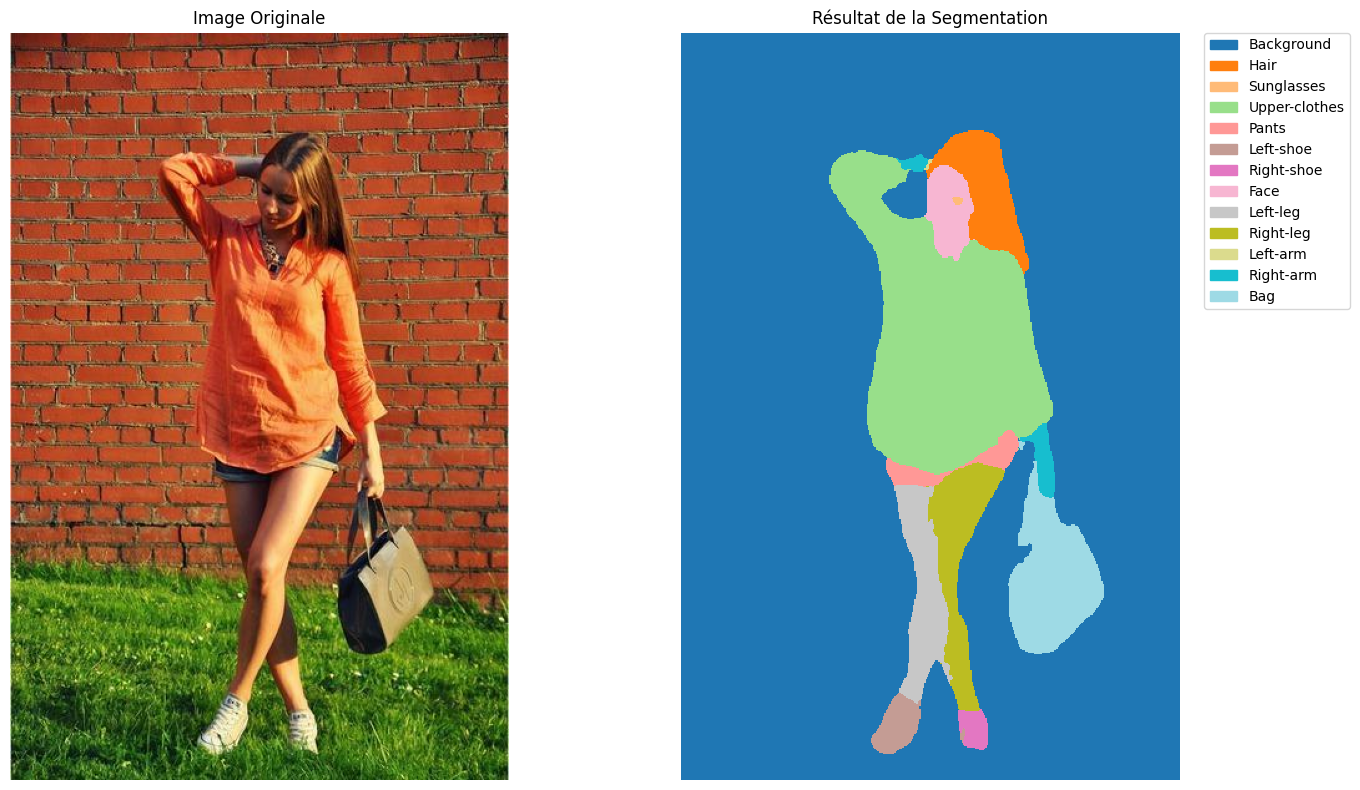

In [24]:
if image_paths:
    single_image_path = os.path.join(image_dir, image_paths[0]) # Prenons la première image de notre liste
    print(f"Traitement de l'image : {single_image_path}")

    try:
        # Lire l'image en binaire
        # Et mettez le contenu de l'image dans la variable image_data
        with open(single_image_path, "rb") as f:
            image_data = f.read() # A vous de jouer !

        # Maintenant, utilisé l'API huggingface
        # ainsi que les fonctions données plus haut pour ségmenter vos images.
        imageType = "image/png"
        headers["Content-Type"] = imageType

        #response = requests.post(API_URL, headers, image_data)

        client = InferenceClient(
        provider="hf-inference",
        api_key=api_token,
        )
        
        #MODELE_TEST = "facebook/detr-resnet-50-panoptic" 
        
        #response = client.image_segmentation(
        #    single_image_path,
        #    model=MODELE_TEST
        #)
        response = client.image_segmentation(single_image_path, model="sayeed99/segformer_b3_clothes")
        # 2. Si le code arrive ici, c'est que l'API a réussi (Code 200).
        # 'response' est maintenant l'objet décodé (une liste de résultats de segmentation).
        # réponse est une liste de dictionnaire. A chaque dictionnaire est associé un label (t-shirt, chaussure) un
        # indice de confiance et le masque associé
        print("Succès, la segmentation a été effectuée.")
        print(f"Type de la réponse : {type(response)}") # Pour voir ce que vous avez
        # Vous pouvez ensuite traiter 'response' pour afficher les masques, etc.


        # 1. Votre fonction de segmentation retourne un masque NumPy
        # Exemple (remplacez cette ligne par l'appel à votre fonction)
        image_width, image_height = get_image_dimensions(single_image_path)
        print(f"Hauteur et largeur de l'image segmentee: {image_width} X {image_height}")
        segmentation_mask = create_masks(response, image_width, image_height)

        
        # 2. Affichage du masque
        print(f"Forme du masque : {segmentation_mask.shape}, Type de données : {segmentation_mask.dtype}")
        
             # --- Configuration de l'affichage côte à côte ---
        # on crée une figure avec 1 ligne et 2 colonnes
        # figsize=(16, 8) permet d'avoir une image assez grande
        fig, axes = plt.subplots(1, 2, figsize=(16, 8)) 
        
        # --- 1. Affichage de l'image Originale (Gauche) ---
        # On charge l'image originale
        original_image = Image.open(single_image_path)
        
        axes[0].imshow(original_image)
        axes[0].set_title("Image Originale")
        axes[0].axis('off') # Enlever les axes X/Y
        
        # --- 2. Affichage du Masque (Droite) ---
        
        # Préparation de la légende (comme avant)
        # on fait le chemin inverse
        id_to_label = {v: k for k, v in CLASS_MAPPING.items()}
        unique_classes = np.unique(segmentation_mask)
        
        # Affichage sur le deuxième axe (axes[1])
        im = axes[1].imshow(segmentation_mask, cmap='tab20', interpolation='nearest')
        axes[1].set_title("Résultat de la Segmentation")
        axes[1].axis('off')
        
        # Création de la légende
        legend_patches = []
        for class_id in unique_classes:
            color = im.cmap(im.norm(class_id))
            label_name = id_to_label.get(class_id, f"Inconnu ({class_id})")
            patch = mpatches.Patch(color=color, label=label_name)
            legend_patches.append(patch)
        
        # On attache la légende au graphique de droite (axes[1])
        axes[1].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
        # Ajustement automatique pour éviter que les éléments se chevauchent
        plt.tight_layout()
        plt.show()



        
    except Exception as e:
        print(f"Une erreur est survenue : {e}")

## 5. Segmentation de Plusieurs Images (Batch)

Maintenant que nous savons comment traiter une image, nous pouvons créer une fonction pour en traiter plusieurs.
Cette fonction va boucler sur la liste `image_paths` et appliquer la logique de segmentation à chaque image.
Nous utiliserons `tqdm` pour avoir une barre de progression.

In [ ]:
def segment_images_batch(list_of_image_paths):
    """
    Segmente une liste d'images en utilisant l'API Hugging Face.

    Args:
        list_of_image_paths (list): Liste des chemins vers les images.

    Returns:
        list: Liste des masques de segmentation (tableaux NumPy).
              Contient None si une image n'a pas pu être traitée.
    """
    batch_segmentations = []

    # N'oubliez pas de mettre une pause entre chaque appel API !


    return batch_segmentations

# Appeler la fonction pour segmenter les images listées dans image_paths
if image_paths:
    print(f"\nTraitement de {len(image_paths)} image(s) en batch...")
    batch_seg_results = segment_images_batch(image_paths)
    print("Traitement en batch terminé.")
else:
    batch_seg_results = []
    print("Aucune image à traiter en batch.")

## 6. Affichage des Résultats en Batch

Nous allons maintenant créer une fonction pour afficher les images originales et leurs segmentations correspondantes côte à côte, dans une grille.

In [ ]:
def display_segmented_images_batch(original_image_paths, segmentation_masks):
    """
    Affiche les images originales et leurs masques segmentés.

    Args:
        original_image_paths (list): Liste des chemins des images originales.
        segmentation_masks (list): Liste des masques segmentés (NumPy arrays).
    """
    # Matplotlib, ça vous parle ?
    # Alors... au travail ! 😉

# Afficher les résultats du batch
if batch_seg_results:
    display_segmented_images_batch(image_paths, batch_seg_results)
else:
    print("Aucun résultat de segmentation à afficher.")

## Conclusion et Prochaines Étapes

Félicitations ! Vous avez appris à :
- Configurer les appels à l'API d'inférence Hugging Face.
- Envoyer des images pour la segmentation.
- Interpréter les résultats (avec l'aide des fonctions fournies).
- Visualiser les segmentations.

Pistes d'amélioration ou d'exploration :
- **Gestion d'erreurs plus fine** : Implémenter des tentatives multiples (retry) en cas d'échec de l'API (par exemple, si le modèle est en cours de chargement).
- **Appels asynchrones** : Pour un grand nombre d'images, des appels asynchrones (avec `asyncio` et `aiohttp`) seraient beaucoup plus rapides.
- **Autres modèles** : Explorer d'autres modèles de segmentation ou d'autres tâches sur Hugging Face Hub.

N'hésitez pas à modifier le code, à tester avec vos propres images et à explorer davantage !

**_Note_** : Si vous aimez ce modèle, n'hésitez pas à le [télécharger](https://huggingface.co/sayeed99/segformer_b3_clothes) et jouer avec directement sur votre machine !